In [1]:
import time
# see last cell for total time taken by this notebook
start_time = time.time()

In [2]:
# to suppress warning from ete3 because it's not up to date with py3.12
import warnings
warnings.filterwarnings("ignore", category=SyntaxWarning)
# Suppress the specific UserWarning from scipy.stats.wilcoxon
warnings.filterwarnings(
    "ignore",
    message="Sample size too small for normal approximation",
    category=UserWarning,
    module="scipy.stats._wilcoxon"
)

In [3]:
import pandas as pd
import numpy as np
import os
import ete3
from scipy import stats
import multiprocessing as mp
from tqdm import tqdm

data_dir = os.path.join(os.path.dirname(os.getcwd()), "data")
filtered_dir = os.path.join(data_dir, "filtered")
compiled_results_dir = os.path.join(data_dir, "compiled_results")
plots_dir = os.path.join(data_dir, "plots")

# suppress settingwithcopywarning
pd.options.mode.chained_assignment = None

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# use seaborn colorblind palette
sns.set_palette("colorblind")
# serif font
mpl.rcParams["font.family"] = "serif"

# Scale the relevant rcParams by 2x
scale_factor = 2
for key in mpl.rcParams:
    try:
        if not "size" in key:
            continue
        if isinstance(mpl.rcParams[key], (int, float)) and not isinstance(
            mpl.rcParams[key], bool
        ):
            mpl.rcParams[key] *= scale_factor
        elif isinstance(mpl.rcParams[key], (list, tuple)):
            mpl.rcParams[key] = [
                (
                    v * scale_factor
                    if isinstance(v, (int, float)) and not isinstance(v, bool)
                    else v
                )
                for v in mpl.rcParams[key]
            ]
    except Exception as e:
        print(f"Error scaling {key} from {mpl.rcParams[key]}: {e}")
        raise e


In [4]:
# read in the NOG-COG-fncategories mapping file
nog_cog_mapping_filepath = os.path.join(filtered_dir, "map.NOG_COG_categories.tsv")
nog_cog_mapping_df = pd.read_csv(nog_cog_mapping_filepath, sep='\t')
# remove \n etc from category names
nog_cog_mapping_df["COG_category_name"] = nog_cog_mapping_df["COG_category_name"].str.strip()

# retrieve branch lengths by reading in the genome tree
genome_tree_filepath = os.path.join(
    data_dir, "genome_tree", "genome_tree.iqtree.treefile.rooted.labeled"
)
# read it in with ete3
genome_tree = ete3.Tree(genome_tree_filepath, format=1)
# get the branch lengths
branch_lengths_dict = {
    branch.name: branch.dist for branch in genome_tree.traverse() if branch.dist > 0
}
# list of branch names
branch_names = list(branch_lengths_dict.keys())

# read in genome sizes of all branches
genome_sizes_filepath = os.path.join(
    data_dir, "inferences", "gene_dynamics", "Count", "Count_genome_sizes.tsv"
)
genome_sizes_df = pd.read_csv(genome_sizes_filepath, sep="\t").rename(
    columns={"node": "branch"}
)
# drop the # PRESENT column
genome_sizes_df = genome_sizes_df.drop(columns=["# PRESENT"])

# read in the ecosystem type gain/loss inferences made by Count: Note that the branch sets with/without EG are identical across Count and GLOOME MP
compiled_ecotype_count_filepath = os.path.join(compiled_results_dir, "compiled_dynamics.branchwise.ecotype.count.tsv")
compiled_ecotype_count_df = pd.read_csv(compiled_ecotype_count_filepath, sep='\t', header=0) # branch, transfers, losses, expansions, reductions
# Add missing branches with zero values for all columns
missing_branches = set(branch_names) - set(compiled_ecotype_count_df["branch"])
missing_branches_df = pd.DataFrame({
    "branch": list(missing_branches),
    "transfers": 0, "losses": 0, "expansions": 0, "reductions": 0
})
compiled_ecotype_count_df = pd.concat([compiled_ecotype_count_df, missing_branches_df], ignore_index=True)
compiled_ecotype_count_df['branch_type'] = np.where(compiled_ecotype_count_df['transfers'] > 0, 'Ecosystem gain', 'No ecosystem gain')

eg0_branch_list = compiled_ecotype_count_df[compiled_ecotype_count_df["transfers"] == 0]["branch"].tolist()
eg1_branch_list = compiled_ecotype_count_df[compiled_ecotype_count_df["transfers"] > 0]["branch"].tolist()

# read in the NOGs that are gained/lost in each branch, specifically for the 'count' gene method
compiled_gene_dynamics_file = os.path.join(compiled_results_dir, "compiled_dynamics.varwise.branchwise.gene.count.tsv")
print("Processing gene method: count")
compiled_gene_dynamics_df = pd.read_csv(compiled_gene_dynamics_file, sep='\t', header=0)

# add the branch lengths to the compiled gene dynamics dataframe
compiled_gene_dynamics_df["branch_length"] = compiled_gene_dynamics_df["branch"].map(branch_lengths_dict)

# add the branch type to the compiled ecotype dynamics dataframe
compiled_ecotype_count_df["branch_length"] = compiled_ecotype_count_df["branch"].map(branch_lengths_dict)

# find the gain/loss rates
compiled_gene_dynamics_df["gain_rate"] = compiled_gene_dynamics_df["transfers"] / compiled_gene_dynamics_df["branch_length"]
compiled_gene_dynamics_df["loss_rate"] = compiled_gene_dynamics_df["losses"] / compiled_gene_dynamics_df["branch_length"]

# add the genome sizes to the compiled gene dynamics dataframe
compiled_gene_dynamics_df = compiled_gene_dynamics_df.merge(genome_sizes_df, on="branch", how="left")

# add the NOG-COG functional categories to the dataframe
compiled_gene_dynamics_df = compiled_gene_dynamics_df.rename(columns={"nog_id": "NOG"})
compiled_gene_dynamics_df = compiled_gene_dynamics_df.merge(nog_cog_mapping_df, on="NOG", 
                                                            how="left" # keep all rows in compiled_gene_dynamics_df but only matching rows in nog_cog_mapping_df
                                                            )

# drop rows where the COG category is not available
compiled_gene_dynamics_df = compiled_gene_dynamics_df.dropna(subset=["COG_category_name"])

# make two dfs out of this based on whether the branch is EG0 or EG1
eg0_compiled_gene_dynamics_df = compiled_gene_dynamics_df[compiled_gene_dynamics_df["branch"].isin(eg0_branch_list)]
eg1_compiled_gene_dynamics_df = compiled_gene_dynamics_df[compiled_gene_dynamics_df["branch"].isin(eg1_branch_list)]
compiled_gene_dynamics_dfs_dict = {"EG0": eg0_compiled_gene_dynamics_df, "EG1": eg1_compiled_gene_dynamics_df, "full": compiled_gene_dynamics_df}

print(f"number of gain/loss events in EG0: {eg0_compiled_gene_dynamics_df.shape[0]}")
print(f"number of gain/loss events in EG1: {eg1_compiled_gene_dynamics_df.shape[0]}")

# display full df
display(compiled_gene_dynamics_df)

Processing gene method: count
number of gain/loss events in EG0: 89812
number of gain/loss events in EG1: 263258


,NOG,branch,transfers,losses,expansions,reductions,branch_length,gain_rate,loss_rate,genes,families,single-member families,COG,COG_category_symbol,COG_category_name,COG_meta_category
0,COG0001,N44,0,2,0,0,0.312913,0.000000,6.391553,4730,2373,1458,COG0001,H,Coenzyme transport and metabolism,METABOLISM
1,COG0001,35841,0,0,0,1,0.553469,0.000000,0.000000,3284,2026,1458,COG0001,H,Coenzyme transport and metabolism,METABOLISM
2,COG0001,260554,0,0,1,0,0.391141,0.000000,0.000000,3708,2181,1546,COG0001,H,Coenzyme transport and metabolism,METABOLISM
3,COG0001,86664,0,0,0,1,0.339108,0.000000,0.000000,3476,2103,1503,COG0001,H,Coenzyme transport and metabolism,METABOLISM
4,COG0001,29382,0,2,0,0,0.158736,0.000000,12.599536,1802,1346,1088,COG0001,H,Coenzyme transport and metabolism,METABOLISM
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
405166,DA5KN,471,1,0,0,0,0.152458,6.559184,0.000000,3587,1980,1392,COG1418,J,"Translation, ribosomal structure and biogenesis",INFORMATION STORAGE AND PROCESSING
405233,DA6FD,N112,0,1,0,0,0.089116,0.000000,11.221355,5675,2251,1450,COG3467,V,Defense mechanisms,CELLULAR PROCESSES AND SIGNALING
405234,DA6FD,1833,0,1,0,0,0.358286,0.000000,2.791066,5473,2100,1301,COG3467,V,Defense mechanisms,CELLULAR PROCESSES AND SIGNALING
405235,DA6FD,2055,0,1,0,0,0.572045,0.000000,1.748114,4811,2019,1304,COG3467,V,Defense mechanisms,CELLULAR PROCESSES AND SIGNALING


,COG_category_name,mwu_stat,mwu_pval,eg0_mean,eg1_mean,difference in means,eg0_std,eg1_std,fdr_pval,significant
0,Chromatin structure and dynamics,16639.5,7.506930e-01,0.104754,0.106238,-0.001485,1.078504,1.619348,8.257623e-01,False
1,Extracellular structures,204480.0,5.372023e-01,0.089240,0.081342,0.007899,1.008711,0.774758,6.565806e-01,False
2,Signal transduction mechanisms,281566823.0,3.604537e-01,0.058418,0.035168,0.023250,0.928896,0.771005,4.664694e-01,False
3,Lipid transport and metabolism,31809014.0,1.276900e-01,0.060804,0.020356,0.040448,1.096346,0.356388,1.872786e-01,False
4,Nucleotide transport and metabolism,6179542.0,8.690241e-01,0.086202,0.042777,0.043425,1.049880,0.636830,9.104062e-01,False
5,"Replication, recombination and repair",15399875.0,8.040565e-02,0.102686,0.056654,0.046032,1.212387,0.836200,1.474104e-01,False
6,Amino acid transport and metabolism,72533404.5,4.420680e-04,0.066441,0.016605,0.049836,0.968982,0.291116,1.984254e-03,True
7,Cell wall/membrane/envelope biogenesis,100670264.5,1.125463e-01,0.085685,0.035576,0.050110,1.191632,0.641452,1.768585e-01,False
8,Inorganic ion transport and metabolism,50253666.0,1.259127e-02,0.082348,0.031659,0.050689,1.054053,0.544672,2.770080e-02,True
9,"Secondary metabolites biosynthesis, transport ...",12109497.5,1.401884e-01,0.152800,0.096251,0.056549,1.717096,1.911638,1.927590e-01,False


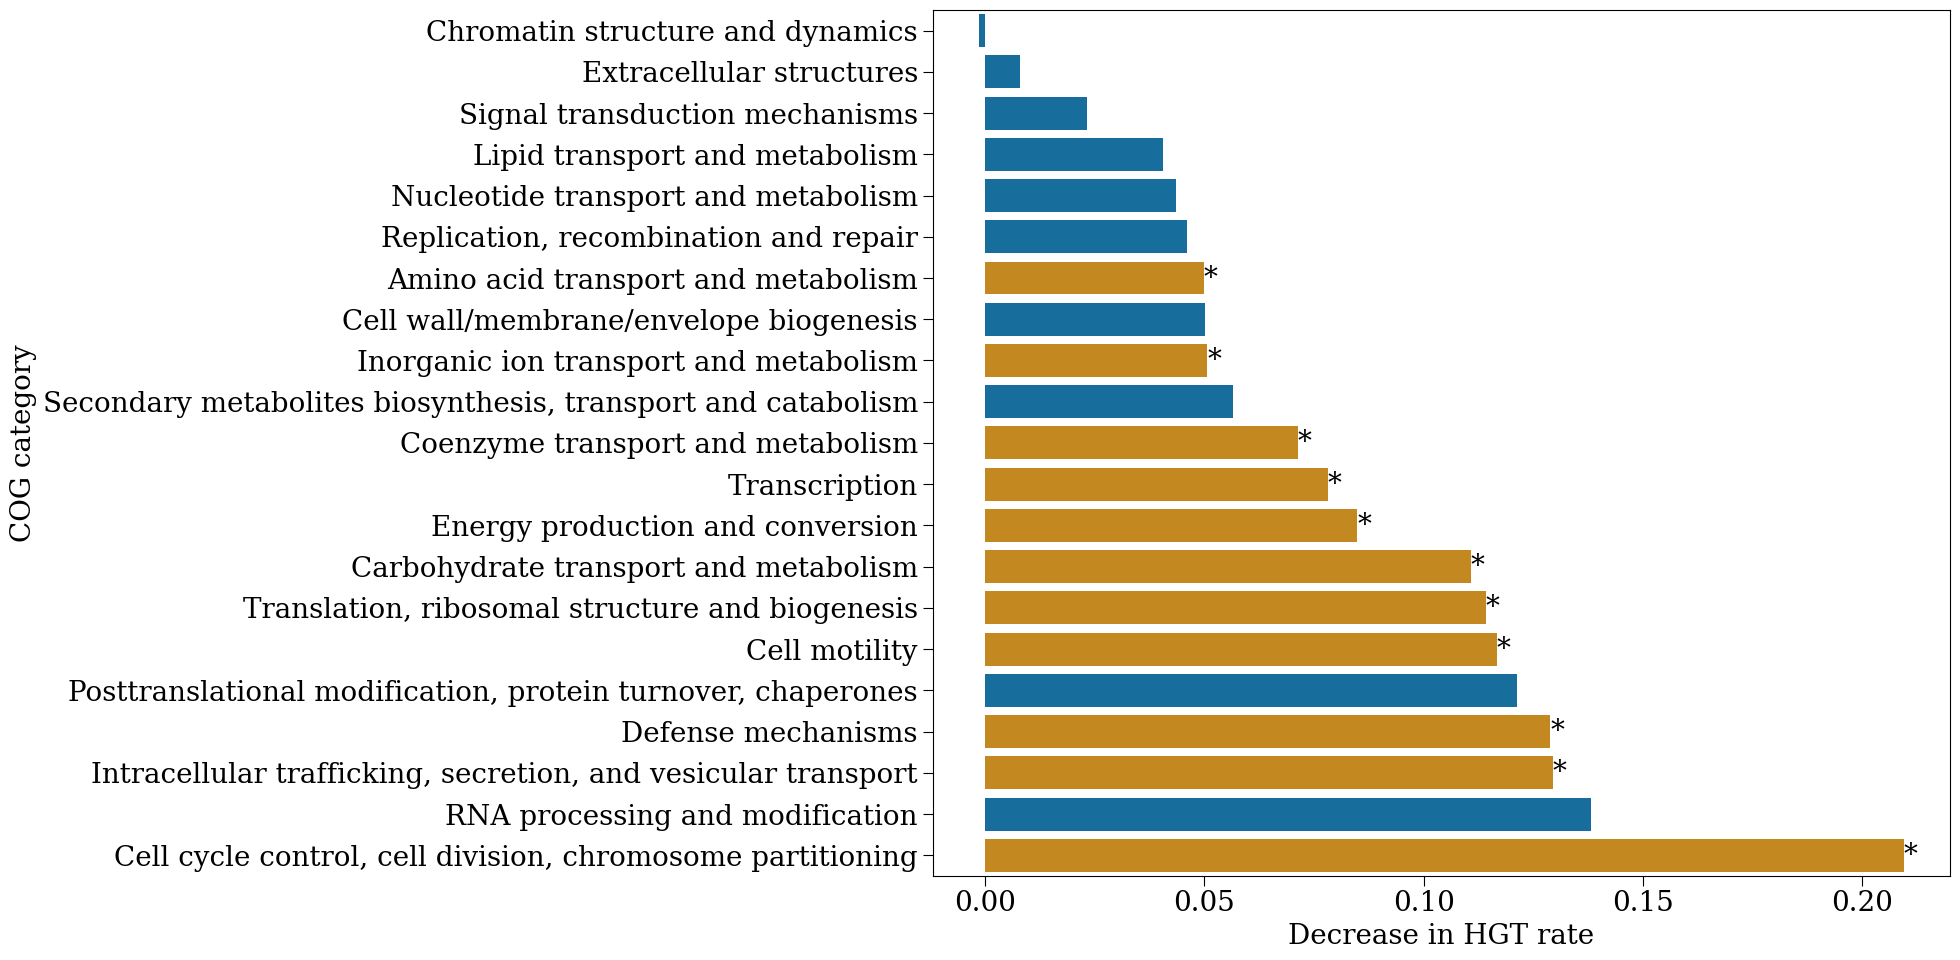

In [5]:
# check if for every given category, given gene method == Count, the gain rates are significantly higher in EG1 branches vs EG0 branches
# we will use the Mann-Whitney U test for this

mwu_cog_count_records_dict = {}
alpha = 0.05
cog_categories = nog_cog_mapping_df["COG_category_name"].unique()
# for each COG category, get the gain rates for EG0 and EG1 branches and perform the Mann-Whitney U test
for cog_category in cog_categories:
    cog_category_df = compiled_gene_dynamics_df[compiled_gene_dynamics_df["COG_category_name"] == cog_category]
    eg0_gain_rates = cog_category_df[cog_category_df["branch"].isin(eg0_branch_list)]["gain_rate"]
    eg1_gain_rates = cog_category_df[cog_category_df["branch"].isin(eg1_branch_list)]["gain_rate"]
    mwu_stat, mwu_pval = stats.mannwhitneyu(eg0_gain_rates, eg1_gain_rates)
    mwu_cog_count_records_dict[cog_category] = {"mwu_stat": mwu_stat, "mwu_pval": mwu_pval,
                                                "eg0_mean": eg0_gain_rates.mean(), "eg1_mean": eg1_gain_rates.mean(),
                                                # difference in means: eg0 - eg1
                                                "difference in means": eg0_gain_rates.mean() - eg1_gain_rates.mean(),
                                                "eg0_std": eg0_gain_rates.std(), "eg1_std": eg1_gain_rates.std()}
# convert the dictionary to a dataframe
mwu_cog_count_records_df = pd.DataFrame.from_dict(mwu_cog_count_records_dict, orient="index")
# correct the p-values for multiple testing using false discovery rate
mwu_cog_count_records_df["fdr_pval"] = stats.false_discovery_control(mwu_cog_count_records_df["mwu_pval"])
mwu_cog_count_records_df['significant'] = mwu_cog_count_records_df['fdr_pval'] < alpha
# sort by p-value and then by difference in means
mwu_cog_count_records_df = mwu_cog_count_records_df.sort_values(by=["difference in means"], ascending=True)
# remove rows with zero difference in means
mwu_cog_count_records_df = mwu_cog_count_records_df[mwu_cog_count_records_df["difference in means"] != 0]
# reset the index and rename the columns
mwu_cog_count_records_df = mwu_cog_count_records_df.reset_index().rename(columns={"index": "COG_category_name"})
display(mwu_cog_count_records_df)

# plot the difference in means as bar plots, with color indicating significance
fig, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x="difference in means", y="COG_category_name", data=mwu_cog_count_records_df,
            hue="significant", 
            ax=ax)
# add significance annotations
for i, row in mwu_cog_count_records_df.iterrows():
    if row["significant"]:
        ax.text(row["difference in means"], i, "*", color="black", va="center")
ax.set_xlabel("Decrease in HGT rate")
ax.set_ylabel("COG category")
# plt.title("Difference in gain rates between EG0 and EG1 branches (gene method: Count)")
plt.tight_layout()
# remove legend
ax.get_legend().remove()
plt.savefig(os.path.join(plots_dir, "difference_in_gain_rates_by_COG_category_count.png"))
plt.show()

In [6]:
# for each COG category, check if after accounting for the genome size
# if the branch type makes any significant difference in the gain rates
# we will use a Generalized Linear Model (GLM) with a log link function
import statsmodels.formula.api as smf
import statsmodels.api as sm
from scipy import stats

min_gene_families_per_category = 20
# get the list of gene families in each COG category
cog_category_gene_families_dict = {}
for cog_category in cog_categories:
    cog_category_df = compiled_gene_dynamics_df[compiled_gene_dynamics_df["COG_category_name"] == cog_category]
    # get the list of gene families in the category
    gene_families = cog_category_df["NOG"].unique()
    # check if there are at least min_gene_families_per_category gene families in the category
    if len(gene_families) >= min_gene_families_per_category:
        cog_category_gene_families_dict[cog_category] = gene_families.tolist()
    else:
        print(f"Skipping {cog_category} because it has only {len(gene_families)} gene families")

# save the dictionary to a file
cog_category_gene_families_filepath = os.path.join(filtered_dir, "map.COG_category_gene_families.tsv")
with open(cog_category_gene_families_filepath, "w") as f:
    f.write("COG_category_name\tgene_families\n")
    for cog_category, gene_families in cog_category_gene_families_dict.items():
        f.write(f"{cog_category}\t{','.join(gene_families)}\n")

# loop over COG categories
lrt_results_dict = {}
for cog_category, gene_families in cog_category_gene_families_dict.items():
    # from the compiled_gene_dynamics_df, retrieve the rows with the gene families in the category
    cog_category_df = compiled_gene_dynamics_df[compiled_gene_dynamics_df["NOG"].isin(gene_families)]
    # groupby branch and and sum the gains and losses
    cog_category_df = cog_category_df.groupby("branch").agg({"transfers": "sum", "losses": "sum"}).reset_index()
    # add the branch length, then calculate the gain and loss rates
    cog_category_df["branch_length"] = cog_category_df["branch"].map(branch_lengths_dict)
    cog_category_df["gain_rate"] = cog_category_df["transfers"] / cog_category_df["branch_length"]
    cog_category_df = cog_category_df[cog_category_df["gain_rate"] > 0]

    cog_category_df["log_gain_rate"] = np.log(cog_category_df["gain_rate"])

    # add the branch type to the dataframe
    cog_category_df = cog_category_df.merge(compiled_ecotype_count_df[["branch", "branch_type"]], on="branch", how="left")
    cog_category_df['ecosystem_gain'] = np.where(cog_category_df['branch_type'] == 'Ecosystem gain', 1, 0)
    # print gain_rate difference across branch set with ecosystem gain and without
    # print(f"COG category: {cog_category}:"
    #         f"EG0 median gain rate: {cog_category_df[cog_category_df['ecosystem_gain'] == 0]['gain_rate'].median()};"
    #         f"EG1 median gain rate: {cog_category_df[cog_category_df['ecosystem_gain'] == 1]['gain_rate'].median()}")
    # this shows that regardless of COG category, EG0 branches have a higher gain rate than EG1 branches

    # add the genome size to the dataframe
    cog_category_df = cog_category_df.merge(genome_sizes_df, on="branch", how="left")
    # full model GLS: gain_rate ~ genes + branch_type
    # check if there are invalid values in the three columns: gain_rate, genes, ecosystem_gain that could raise RuntimeWarning, show those rows
    invalid_rows = cog_category_df[
        cog_category_df[["gain_rate", "genes", "ecosystem_gain"]].isnull().any(axis=1)
    ]
    if not invalid_rows.empty:
        print(f"Invalid rows in {cog_category}:")
        display(invalid_rows)
    model_with_eg = smf.glm(
        "gain_rate ~ genes + ecosystem_gain",
        data=cog_category_df,
    ).fit()
    # model without EG: gain_rate ~ genes
    model_without_eg = smf.glm(
        "gain_rate ~ genes",
        data=cog_category_df,
    ).fit()
    # compare the models using LRT (with EG vs without EG)
    # llr> 0 => model with EG is better
    llr = 2 * (model_with_eg.llf - model_without_eg.llf)
    pval = stats.chi2.sf(llr, 1)
    # store the results in a dictionary
    lrt_results_dict[cog_category] = {
        "Log Likelihood Ratio": llr,
        "p-value": pval,
        "Median HGT rate (NEG)": cog_category_df[cog_category_df["ecosystem_gain"] == 0]["gain_rate"].median(),
        "Median HGT rate (EG)": cog_category_df[cog_category_df["ecosystem_gain"] == 1]["gain_rate"].median(),
        "Coefficient of EG": model_with_eg.params["ecosystem_gain"],
        "EG p-value": model_with_eg.pvalues["ecosystem_gain"],
    }
    # if llr is nan
    if np.isnan(llr):
        print(model_with_eg.summary())
        print(model_without_eg.summary())
# convert the dictionary to a dataframe
lrt_results_df = pd.DataFrame.from_dict(lrt_results_dict, orient="index")
# correct the p-values for multiple testing using false discovery rate
lrt_results_df["p-value (FDR corrected)"] = stats.false_discovery_control(lrt_results_df["p-value"])
lrt_results_df["significant"] = lrt_results_df["p-value (FDR corrected)"] < alpha
# sort by p-value and then by llr
lrt_results_df = lrt_results_df.sort_values(by=["p-value (FDR corrected)", "Log Likelihood Ratio"], ascending=True)
# remove rows with zero llr
lrt_results_df = lrt_results_df[lrt_results_df["Log Likelihood Ratio"] != 0]
# add column for lrt > 1
lrt_results_df["lrt > 1"] = lrt_results_df["Log Likelihood Ratio"] > 1
# reset the index and rename the columns
lrt_results_df = lrt_results_df.reset_index().rename(
    columns={"index": "COG category"}
)
# display the results
display(lrt_results_df)

# same df without the cols: significant and lrt > 1
lrt_results_df_minimal = lrt_results_df.drop(columns=["significant", "lrt > 1", "p-value"])
# rearrange columns to put Log Likelihood Ratio and p-value (FDR corrected) at the end
lrt_results_df_minimal = lrt_results_df_minimal[["COG category", "Median HGT rate (NEG)", "Median HGT rate (EG)", 
                                                 "Log Likelihood Ratio", "p-value (FDR corrected)"]]
# print latex table with 2 significant digits
latex_table = lrt_results_df_minimal.to_latex(index=False, float_format="%.2f", escape=False)
print(latex_table) 

Skipping Chromatin structure and dynamics because it has only 7 gene families
Skipping Cytoskeleton because it has only 1 gene families


,COG category,Log Likelihood Ratio,p-value,Median HGT rate (NEG),Median HGT rate (EG),Coefficient of EG,EG p-value,p-value (FDR corrected),significant,lrt > 1
0,Amino acid transport and metabolism,23.094018,0.000002,16.014939,5.157058,-20.086745,3.703373e-07,0.000031,True,True
1,Transcription,7.995181,0.004690,26.941365,6.079274,-28.943237,4.465026e-03,0.046902,True,True
2,Carbohydrate transport and metabolism,5.461045,0.019445,15.751843,8.683355,-31.378348,1.964303e-02,0.097225,False,True
3,RNA processing and modification,5.706321,0.016904,11.416394,3.676187,-12.014813,2.030249e-02,0.097225,False,True
4,"Posttranslational modification, protein turnov...",4.527678,0.033351,16.465242,5.469233,-27.896351,3.422217e-02,0.133403,False,True
5,Lipid transport and metabolism,3.828460,0.050389,9.843343,6.018204,-9.065843,5.259205e-02,0.167964,False,True
6,Defense mechanisms,3.520018,0.060632,17.870583,6.015190,-10.075907,6.248745e-02,0.173234,False,True
7,Energy production and conversion,2.689983,0.100981,13.754137,7.942834,-16.630077,1.042698e-01,0.201962,False,True
8,Cell motility,2.705868,0.099980,14.446661,5.616842,-8.905135,1.082455e-01,0.201962,False,True
9,Coenzyme transport and metabolism,2.719639,0.099120,13.019785,7.511121,-11.029091,1.033975e-01,0.201962,False,True


\begin{tabular}{lrrrr}
\toprule
COG category & Median HGT rate (NEG) & Median HGT rate (EG) & Log Likelihood Ratio & p-value (FDR corrected) \\
\midrule
Amino acid transport and metabolism & 16.01 & 5.16 & 23.09 & 0.00 \\
Transcription & 26.94 & 6.08 & 8.00 & 0.05 \\
Carbohydrate transport and metabolism & 15.75 & 8.68 & 5.46 & 0.10 \\
RNA processing and modification & 11.42 & 3.68 & 5.71 & 0.10 \\
Posttranslational modification, protein turnover, chaperones & 16.47 & 5.47 & 4.53 & 0.13 \\
Lipid transport and metabolism & 9.84 & 6.02 & 3.83 & 0.17 \\
Defense mechanisms & 17.87 & 6.02 & 3.52 & 0.17 \\
Energy production and conversion & 13.75 & 7.94 & 2.69 & 0.20 \\
Cell motility & 14.45 & 5.62 & 2.71 & 0.20 \\
Coenzyme transport and metabolism & 13.02 & 7.51 & 2.72 & 0.20 \\
Translation, ribosomal structure and biogenesis & 12.83 & 5.81 & 1.59 & 0.38 \\
Nucleotide transport and metabolism & 6.36 & 5.74 & 1.18 & 0.43 \\
Intracellular trafficking, secretion, and vesicular transport & 7.61

/tmp/ipykernel_2894325/3025785857.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Log Likelihood Ratio", y="COG category", data=lrt_results_df,
/tmp/ipykernel_2894325/3025785857.py:3: UserWarning: 
The palette list has fewer values (1) than needed (20) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x="Log Likelihood Ratio", y="COG category", data=lrt_results_df,
/tmp/ipykernel_2894325/3025785857.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(new_labels)


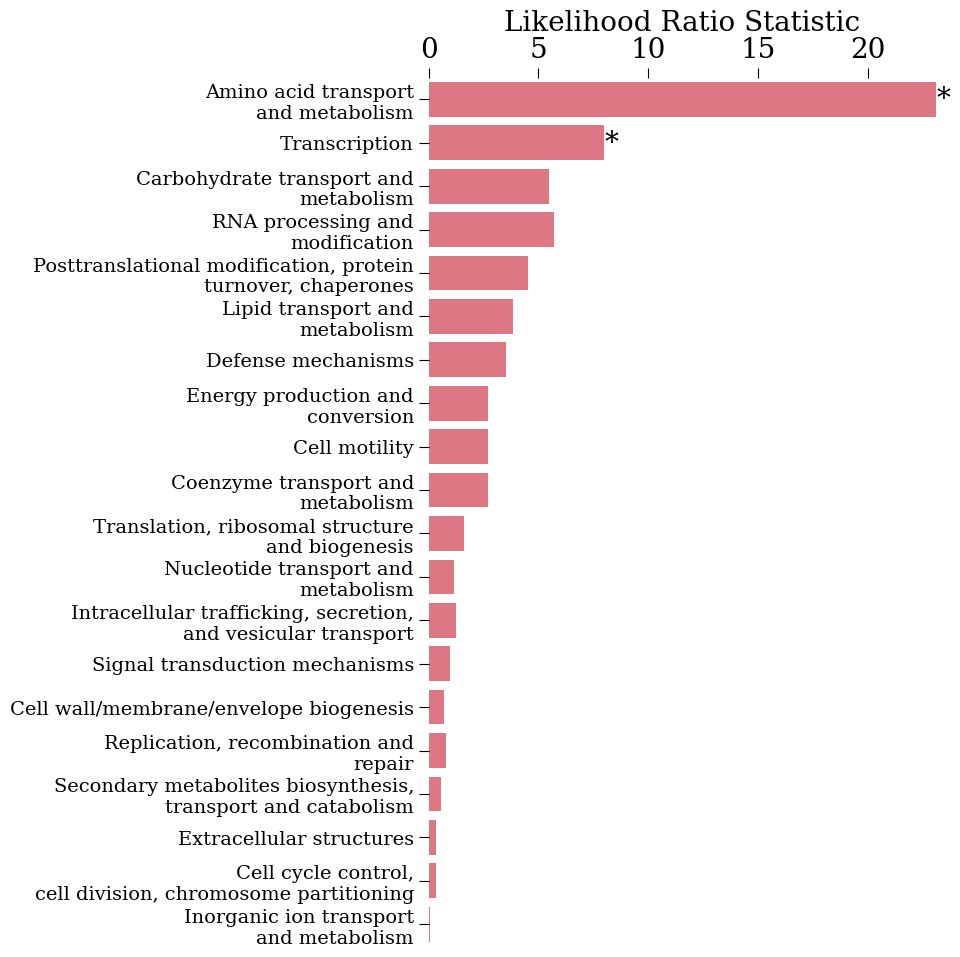

In [7]:
# plot lrt results as horizontal bar plot, with color indicating significance
fig, ax = plt.subplots(figsize=(10, 10))
sns.barplot(x="Log Likelihood Ratio", y="COG category", data=lrt_results_df,
            # hue="lrt > 1", 
            # palette=['#4477AA', '#EE6677'],
            palette=['#EE6677'],
            ax=ax)
# add significance annotations
for i, row in lrt_results_df.iterrows():
    if row["significant"]:
        ax.text(row["Log Likelihood Ratio"], i, "*", color="black", va="center")
ax.set_xlabel("Likelihood Ratio Statistic")
ax.set_ylabel("")
# make the y-axis labels smaller
ylabel_scale = 0.7
ax.tick_params(axis='y', labelsize=int(ax.yaxis.label.get_size() * ylabel_scale))
# split the y-axis labels into two lines if they have more than 3 words
new_labels = []
for label in ax.get_yticklabels():
    if len(label.get_text().split()) > 3:
        # split the label into two lines after the first 3 words
        words = label.get_text().split()
        new_label = " ".join(words[:3]) + "\n" + " ".join(words[3:])
        new_labels.append(new_label)
    else:
        new_labels.append(label.get_text())
ax.set_yticklabels(new_labels)

# Tufte style
# set the x-axis limits to be minimum and maximum of the Log Likelihood Ratio
ax.set_xlim(left=0, right=lrt_results_df["Log Likelihood Ratio"].max())
# add max xlim to the x-ticks
# max_xlim = lrt_results_df["Log Likelihood Ratio"].max()
# # get the current x-ticks
# current_xticks = ax.get_xticks()
# # if the max xlim is not in the current x-ticks, add it
# if max_xlim not in current_xticks:
#     # add it to the x-ticks
#     ax.set_xticks(list(current_xticks) + [max_xlim])
# move x-axis and label to the top
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')
# remove the left, top and right spines
sns.despine(ax=ax, left=True, bottom=True, right=True)

# plt.title("Likelihood Ratio Test: Ecosystem gain effect on HGT rate")
plt.tight_layout()
# remove legend
# ax.get_legend().remove()
plt.savefig(os.path.join(plots_dir, "lrt_ecosystem_gain_effect_on_HGT_rate.png"))
plt.show()


The above shows functional categories for which, a model with ecosystem gains has a higher Log Likelihood than a model without ecosystem gains. 

In [8]:
# total time taken by this notebook
print("Total time taken (hh:mm:ss): ", time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time)))

Total time taken (hh:mm:ss):  00:00:05
